All files were found for Case-16-MESAL-5014832-E3
Vx3 File: z:/D-Images/MESAL-3/2-Checked-Done-Temp/Done/Case-16-MESAL-5014832-E3\Markups\88-Jensen\Vx3.nrrd
Mask File: z:/D-Images/MESAL-3/2-Checked-Done-Temp/Done/Case-16-MESAL-5014832-E3\seg_net\MESAL-5014832-E3_TLC_120kV_0.75mm_Qr40d.mask.nii.gz
Label File: z:/D-Images/MESAL-3/2-Checked-Done-Temp/Done/Case-16-MESAL-5014832-E3\Markups\88-Jensen\S-Final-2-label.nrrd
Data Shape: (667, 416, 690)
Data Type: int16
Header: OrderedDict([('type', 'short'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([667, 416, 690])), ('space directions', array([[0.38, 0.  , 0.  ],
       [0.  , 0.38, 0.  ],
       [0.  , 0.  , 0.38]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([-120.6, -204.2, -672.9]))])
Reading Vx3...
Spacing: (0.38000000000000006, 0.38000000000000006, 0.38000000000000006)


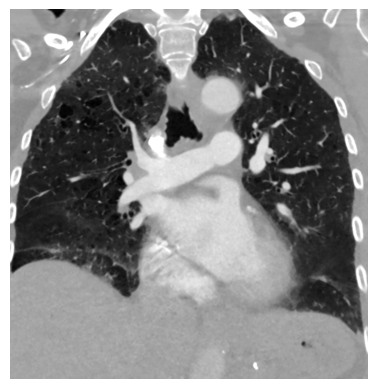

Image saved at: z:/Q- Figures/T32-Poster/Nate/Experiment/-QC-Image.png
Scale bar added and image saved.
Vseed Segmentation conversion complete.
Aseed.nrrd created!
Aseed Segmentation Conversion Complete
Process Completed
Conversion complete.
yay
yay
yay
Lung conversion complete.
Camera Position [   6.13  474.84 -541.8 ]
Camera Focal Point [   6.13 -125.16 -541.8 ]
Origin:  (-120.6, -204.2, -672.8999999999997)
Dimensions:  (667, 416, 690)
Center:  [   6.13 -125.16 -541.8 ]
Process Completed
All files were found for Case-20-MESAL-7015569-E3
Vx3 File: z:/D-Images/MESAL-3/2-Checked-Done-Temp/Done/Case-20-MESAL-7015569-E3\MarkUps\88-Jensen\Vx3.nrrd
Mask File: z:/D-Images/MESAL-3/2-Checked-Done-Temp/Done/Case-20-MESAL-7015569-E3\seg_net\MESAL-7015569-E3_TLC_120kV_0.75mm_Qr40d.mask.nii.gz
Label File: z:/D-Images/MESAL-3/2-Checked-Done-Temp/Done/Case-20-MESAL-7015569-E3\MarkUps\88-Jensen\S-Final-2-label.nrrd
Data Shape: (611, 477, 567)
Data Type: int16
Header: OrderedDict([('type', 'short'), (

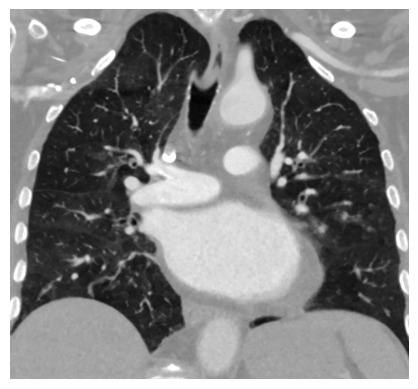

Image saved at: z:/Q- Figures/T32-Poster/Nate/Experiment/-QC-Image.png
Scale bar added and image saved.
Vseed Segmentation conversion complete.
Aseed.nrrd created!
Aseed Segmentation Conversion Complete
Process Completed
Conversion complete.
yay
yay
yay
Lung conversion complete.
Camera Position [  -9.11  455.73 -147.37]
Camera Focal Point [  -9.11 -144.27 -147.37]
Origin:  (-125.20000000000005, -234.9, -255.10000000000002)
Dimensions:  (611, 477, 567)
Center:  [  -9.11 -144.27 -147.37]
Process Completed


: 

In [1]:
# This code creates coronal slice image, 3D segmentation image, and 3D lung Mask if the segmentations and label maps were created correctly
# Just change the base folder to the folder to the "/Done/" folder for either spiromics and mesa 
import os
import pandas as pd
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import nrrd
from PIL import Image, ImageDraw
import os
import vtk
from mayavi import mlab

# Keep Case Numbers undefined if the previous code blocks were ran, otherwise you can specify a case number to choose to run through the image creation program
case_numbers = [16, 20]

def find_files(folder_path):
    vx3_file = None
    mask_file = None
    label_file = None
    
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file == "Vx3.nrrd":
                vx3_file = os.path.join(root, file)
            elif file.endswith(".mask.nii.gz"):
                mask_file = os.path.join(root, file)
            elif file.endswith("label.nrrd"):
                label_file = os.path.join(root, file)
        
        if vx3_file and mask_file and label_file:
            break  # All files are found, exit the loop
    
    return vx3_file, mask_file, label_file


# Define the folder you are reading too
# Writing will occur in the ""./Q- Figures/T32-Poster/Nate/Experiments
base_folder = "z:/D-Images/MESAL-3/2-Checked-Done-Temp/Done/"

for case_number in case_numbers:
    case_folder_prefix = f"Case-{case_number}-"
    
    for folder in os.listdir(base_folder):
        if folder.startswith(case_folder_prefix):
            folder_path = os.path.join(base_folder, folder)
            vx3_file, mask_file, label_file = find_files(folder_path)

            if vx3_file and mask_file and label_file:
                print("All files were found for", folder)
                print("Vx3 File:", vx3_file)
                print("Mask File:", mask_file)
                print("Label File:", label_file)
            
                ############################################################################################################################################################
                # QC IMAGE Creation
                Vx3Path = vx3_file
                labelpath = label_file
                maskpath = mask_file
                output_path = 'z:/Q- Figures/T32-Poster/Nate/Experiment/'
                filename = output_path + "-QC-Image.png"
                final_filename = output_path + "-QC-Image(2CM).png"
                Vx3_path = Vx3Path
                
                # 3D Screenshot Stuff check for repeats
                nrrd_file_path = labelpath
                segmentation_path = labelpath
                case_number = folder
                output_path_seg = 'z:/Q- Figures/T32-Poster/Nate/Experiment/'  # Change this to your desired output directory
                output_nrrd_file_path = "z:/Q- Figures/T32-Poster/Nate/Experiment/"

                # These filenames are just to have the program run all at the same time
                Aseed_filename_base = case_number + "Aseed"
                Vseed_filename_base = case_number + "Vseed"

                # File name conventions
                vtk_filename_aseed = f"{Aseed_filename_base}.vtk"
                vtk_filename_vseed = f"{Vseed_filename_base}.vtk"
                output_filename_aseed = output_path_seg + vtk_filename_aseed
                output_filename_vseed = output_path_seg + vtk_filename_vseed
                screenshot_filename = "Model.png"

                # create QC images folder if it doesn't exist
                models_folder = os.path.join(os.path.dirname(output_path), "QC-Images")
                os.makedirs(models_folder, exist_ok=True)

                # Load the image using nibabel to see image information
                data, header = nrrd.read(Vx3_path)

                # Print the metadata
                print("Data Shape:", data.shape)
                print("Data Type:", data.dtype)
                print("Header:", header)

                # Load the 3D image
                Vx3 = sitk.ReadImage(Vx3_path)
                print("Reading Vx3...")
                # Get the size of the image in x, y, and z dimensions
                size_x, size_y, size_z = Vx3.GetSize()
                spacing = Vx3.GetSpacing()
                y_index = Vx3.GetSize()[1] // 2
                print("Spacing:", spacing)

                # Extract the middle plane along the y-dimension
                slice_2d = Vx3[:,y_index,:]
                slice_array = sitk.GetArrayFromImage(slice_2d)

                # Set the Window level
                window_level_min = -1024  # Adjust these values according to your preference
                window_level_max = 650

                # Apply Window Level to image
                windowed_image = sitk.IntensityWindowing(slice_2d, window_level_min, window_level_max, 0, 255)
                windowed_slice_array = sitk.GetArrayFromImage(windowed_image)

                #Show Vx3 with correct window level
                plt.imshow(windowed_slice_array, cmap="gray",origin='lower')
                plt.axis("off")
                plt.show()

                # Save the Corrected Vx3 .PNG to output path
                output_file_path = os.path.join(models_folder, filename)
                plt.imsave(filename, windowed_slice_array, cmap="gray", origin='lower')
                print("Image saved at:", output_file_path)

                # Load the image
                image_path = filename
                output_path_png = output_path + "/QC-Images/" + case_folder_prefix + "QC-Image(2CM).png"
                image = Image.open(image_path)

                # Determine line position
                line_start_x = 65 # 65 pixels from the left
                line_start_y = image.height - 35 # 35 pixels from the bottom

                # Calculate line end position
                line_end_x = line_start_x + int(20 / 0.38)  # 10 cm converted to pixels
                line_end_y = line_start_y

                # Draw the white line
                draw = ImageDraw.Draw(image)
                draw.line([(line_start_x, line_start_y), (line_end_x, line_end_y)], fill='white', width=2)
                # # Save the modified image
                image.save(output_path_png)

                print("Scale bar added and image saved.")

                #############################################################################################################################################################


                def update_camera_info(obj, evt):
                    camera = mlab.gcf().scene.camera
                    print("Camera Position:", camera.position)
                    print("Camera Focal Point:", camera.focal_point)
                    print("Camera View Up:", camera.view_up)


                # This line creates Models Forlder if not already made
                if not os.path.exists(output_path_seg):
                    os.makedirs(output_path_seg)


                # Load the .nrrd segmentation for Vseed
                nrrd_reader_vseed = vtk.vtkNrrdReader()
                nrrd_reader_vseed.SetFileName(segmentation_path)
                nrrd_reader_vseed.Update()

                vtk_image_data_vseed = vtk.vtkImageData()
                vtk_image_data_vseed.DeepCopy(nrrd_reader_vseed.GetOutput())

                # Define scalar value for "Vseed" segment
                vseed_scalar_value = 2

                # Create a Marching Cubes filter for "Vseed" segment
                contour_vseed = vtk.vtkMarchingCubes()
                contour_vseed.SetInputData(vtk_image_data_vseed)
                contour_vseed.SetValue(0, vseed_scalar_value)
                contour_vseed.Update()

                # Write the "Vseed" mesh to a .vtk file
                vtk_writer_vseed = vtk.vtkPolyDataWriter()
                vtk_writer_vseed.SetFileName(output_filename_vseed) 
                vtk_writer_vseed.SetInputData(contour_vseed.GetOutput())
                vtk_writer_vseed.Write()

                print("Vseed Segmentation conversion complete.")

                # Read the .nrrd file
                data, header = nrrd.read(nrrd_file_path)
                # This reads the labelamp but finds where all the points of 2 are and makes them 0 to make the A model
                data[data == 2] = 0 
                output_nrrd_file_path = output_path + "Segmentation(Aseed).nrrd"
                # Write the modified data and header to a new .nrrd file
                nrrd.write(output_nrrd_file_path, data, header)
                print("Aseed.nrrd created!")
                # Load the .nrrd segmentation for Aseed
                nrrd_reader_aseed = vtk.vtkNrrdReader()
                nrrd_reader_aseed.SetFileName(output_nrrd_file_path)
                nrrd_reader_aseed.Update()

                vtk_image_data_aseed = vtk.vtkImageData()
                vtk_image_data_aseed.DeepCopy(nrrd_reader_aseed.GetOutput())

                # Define scalar value for "Aseed" segment
                aseed_scalar_value = 1

                # Create a Marching Cubes filter for "Aseed" segment
                contour_aseed = vtk.vtkMarchingCubes()
                contour_aseed.SetInputData(vtk_image_data_aseed)
                contour_aseed.SetValue(0, aseed_scalar_value)
                contour_aseed.Update()

                # Write the "Aseed" mesh to a .vtk file
                vtk_writer_aseed = vtk.vtkPolyDataWriter()
                vtk_writer_aseed.SetFileName(output_filename_aseed) 
                vtk_writer_aseed.SetInputData(contour_aseed.GetOutput())
                vtk_writer_aseed.Write()

                print("Aseed Segmentation Conversion Complete")

                #CHANGE THIS SELECT FOLDER TO SAVE TOO AND FILE NAME OF .PNG
                screenshot_output = output_path_seg + case_number + screenshot_filename

                mlab.figure(bgcolor=(1, 1, 1))
                srcA = mlab.pipeline.open(output_filename_aseed)
                srcV = mlab.pipeline.open(output_filename_vseed)

                # Create a surface visualization of the data with blue color and 50% opacity
                surfaceA = mlab.pipeline.surface(srcA, color=(0, 151/255, 206/255), opacity=1)
                surfaceV = mlab.pipeline.surface(srcV, color=(216/255, 101/255, 79/255), opacity=1)

                # Find Segmentation Center
                model = sitk.ReadImage(segmentation_path)
                origin = model.GetOrigin()
                dimensions = model.GetSize()
                direction = model.GetDirection()
                spacing = (0.38, 0.38, 0.38)
                distance = np.array(spacing) * np.array(dimensions)
                center = np.array(origin) + np.array(distance) / 2

                # This 600 is 60 cm away from the coronal plane from behind
                x, y, z = center[0], center[1], center[2]
                ypt = y + 600

                camera_focal_point = np.array([x, y, z])
                camera_position = np.array([x,ypt,z])

                # Set the camera parameters
                # Write code to calculate this
                mlab.gcf().scene.camera.position = [x, ypt, z]
                mlab.gcf().scene.camera.focal_point = [x, y, z]
                mlab.gcf().scene.camera.view_up = [0, 0, 1]

                # Attach the callback to the interaction event
                mlab.gcf().scene.interactor.add_observer('MouseMoveEvent', update_camera_info)

                magnification_factor = 5
                mlab.savefig(screenshot_output, magnification=magnification_factor)


                print("Process Completed")

                ###################################################################################################################################################################

                # 2 to fix (nearly done)
                ## THIS CODE WORKS TO MAKE A MODEL AND POSITION IT AT A FAVORABLE ANGLE TO TAKE AN IMAGE OF THE MAYAVI REPRESENTATION OF THE MODEL

                # QC IMAGE STUFF
                # Casename = "H-14479_JH110088_SPI-JH110088-PBV_SPIROMICS_EXPIRATION_PBV__0.5__QR40__RESEARCH__A_80KV_Qr40d_3_53062428"

                # 3D Screenshot Stuff check for repeats
                nrrd_file_path = labelpath
                segmentation_path = labelpath
                # output_nrrd_file_path = "z:/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done/Case-59-Spiromics-44556786/Markups/88-Nate/Aseed.nrrd"

                # Path to the input NIfTI file
                input_nifti_path_mask = maskpath
                # Path to save the output NRRD file
                output_nrrd_path_mask = 'z:/Q- Figures/T32-Poster/Nate/Experiment/Case-N-Lung-Mask(TEMP).nrrd'
                # Load the NIfTI image
                nifti_image = sitk.ReadImage(input_nifti_path_mask)
                # Create a writer for NRRD format
                nrrd_writer = sitk.ImageFileWriter()
                nrrd_writer.SetFileName(output_nrrd_path_mask)
                # Convert the NIfTI image to a Numpy array
                nifti_array = sitk.GetArrayFromImage(nifti_image)
                # Convert the Numpy array back to a SimpleITK image
                nrrd_image = sitk.GetImageFromArray(nifti_array)
                # Copy information (metadata) from NIfTI image to NRRD image
                nrrd_image.CopyInformation(nifti_image)
                # Write the NRRD image
                nrrd_writer.Execute(nrrd_image)
                print("Conversion complete.")

                masknrrdpath = output_nrrd_path_mask

                # These filenames are just to have the program run all at the same time
                rLung_filename_base = case_number + "Lungs"
                Aseed_filename_base = case_number + "Aseed"

                vtk_filename_rLung = f"{rLung_filename_base}.vtk"
                vtk_filename_Aseed = f"{Aseed_filename_base}.vtk"
                output_filename_rLung = output_path_seg + vtk_filename_rLung
                output_filename_Aseed = output_path_seg + vtk_filename_Aseed
                lung_screenshot_filename = "Lung-Mask.png"
                print("yay")
                # This line creates Models Forlder if not already made
                if not os.path.exists(output_path_seg):
                    os.makedirs(output_path_seg)

                data, header = nrrd.read(output_nrrd_path_mask)
                data[data == 17] = 3
                data[data == 5] = 3
                print("yay")
                # Load the .nrrd segmentation for Vseed
                nrrd_reader_rLung = vtk.vtkNrrdReader()
                nrrd_reader_rLung.SetFileName(output_nrrd_path_mask)
                nrrd_reader_rLung.Update()

                vtk_image_data_rLung = vtk.vtkImageData()
                vtk_image_data_rLung.DeepCopy(nrrd_reader_rLung.GetOutput())

                # Define scalar value for "Vseed" segment
                rLung_scalar_value = 3

                # Create a Marching Cubes filter for "Vseed" segment
                contour_rLung = vtk.vtkMarchingCubes()
                contour_rLung.SetInputData(vtk_image_data_rLung)
                contour_rLung.SetValue(0, rLung_scalar_value)
                contour_rLung.Update()
                print("yay")
                # Write the "Vseed" mesh to a .vtk file
                vtk_writer_rLung = vtk.vtkPolyDataWriter()
                vtk_writer_rLung.SetFileName(output_filename_rLung)
                vtk_writer_rLung.SetInputData(contour_rLung.GetOutput())
                vtk_writer_rLung.Write()
                print("Lung conversion complete.")

                #CHANGE THIS SELECT FOLDER TO SAVE TOO AND FILE NAME OF .PNG
                screenshot_output = output_path_seg + case_number + lung_screenshot_filename
                mlab.figure(bgcolor=(1, 1, 1))
                srcrLung = mlab.pipeline.open(output_filename_rLung)
                srcAseed = mlab.pipeline.open(output_filename_Aseed)

                # Create a surface visualization of the data with blue color and 50% opacity
                surfaceR = mlab.pipeline.surface(srcrLung, color=(128/255, 174/255, 128/255), opacity=.15)
                surfaceAseed = mlab.pipeline.surface(srcAseed, color=(0, 151/255, 206/255), opacity=1)

                x, y, z = center[0], center[1], center[2]
                ypt = y + 600

                camera_focal_point = np.array([x, y, z])
                camera_position = np.array([x,ypt,z])

                print("Camera Position", camera_position)
                print("Camera Focal Point", camera_focal_point)

                # Set the camera parameters
                # Write code to calculate this
                mlab.gcf().scene.camera.position = [x, ypt, z]
                mlab.gcf().scene.camera.focal_point = [x, y, z]
                mlab.gcf().scene.camera.view_up = [0, 0, 1]

                print("Origin: ", origin)
                print("Dimensions: ", dimensions)
                print("Center: ", center)

                # Attach the callback to the interaction event

                magnification_factor = 5
                mlab.savefig(screenshot_output, magnification=magnification_factor)
                
                
                print("Process Completed")

            else:
                print("One or more files were not found for", folder)

            
           
            

In [ ]:
# Working to write to word documents for images after the lung mask and segmentation are in same file, coronal images in different file
from docx import Document
import glob
from PIL import Image
from docx.shared import Inches, Cm, Pt
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.enum.table import WD_ALIGN_VERTICAL

doc = Document()
num_rows = 78
num_cols = 5
table = doc.add_table(rows=num_rows, cols=num_cols)
table.style = 'Table Grid'



titles = ["Index", "Case Number", "Coronal Image", "3D Segmentation", "3D Lung Mask"]
header_cells = table.rows[0].cells
for i in range(num_cols):
    header_cells[i].text = titles[i]

image_folder = 'Z:/Q- Figures/T32-Poster/Nate/Experiment/QC-Images/'
lung_mask_folder = 'Z:/Q- Figures/T32-Poster/Nate/Experiment/3D Images/'
model_image_folder = 'Z:/Q- Figures/T32-Poster/Nate/Experiment/3D Images/'

image_files = glob.glob(image_folder + '/*.png')
lung_mask_files = glob.glob(lung_mask_folder + '/*Lung-Mask.png')
model_image_files = glob.glob(model_image_folder + '/*Model.png')

print('going into loop')

for row_index, (image_path, lung_mask_path, model_image_path) in enumerate(zip(image_files, lung_mask_files, model_image_files), start=1):
    row = table.rows[row_index].cells
    img = Image.open(image_path)
    lung_mask_img = Image.open(lung_mask_path)
    model_img = Image.open(model_image_path)
    new_width = int(img.width)
    segmentation_width = int(lung_mask_img.width)

    row[0].text = str(row_index)
    model_filename = model_image_path.split('\\')[-1]  # Split by backslash and take the last part
    case_number1 = model_filename.replace('Model.png', '')  # Remove '_Model.png' suffix
    row[1].text = case_number1
    
    
    cell = row[2]
    cell.vertical_alignment = WD_ALIGN_VERTICAL.CENTER
    cell_paragraph = cell.paragraphs[0]
    cell_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER
    run = cell_paragraph.add_run()
    run.add_picture(image_path, width=Cm(new_width/300))
    
    model_cell = row[3]  # 4th column
    model_cell.vertical_alignment = WD_ALIGN_VERTICAL.CENTER
    model_paragraph = model_cell.paragraphs[0]
    model_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER
    model_run = model_paragraph.add_run()
    model_run.add_picture(model_image_path, width=Cm(segmentation_width/500))
    
    lung_mask_cell = row[4]
    lung_mask_cell.vertical_alignment = WD_ALIGN_VERTICAL.CENTER
    lung_mask_paragraph = lung_mask_cell.paragraphs[0]
    lung_mask_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER
    lung_mask_run = lung_mask_paragraph.add_run()
    lung_mask_run.add_picture(lung_mask_path, width=Cm(segmentation_width/600))

for row in table.rows:
    for cell in row.cells[:2]:
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                font = run.font
                font.size = Pt(4)  # Adjust font size as needed

output_path = 'Z:/Q- Figures/T32-Poster/Nate/Experiment/CaseImages.docx'
doc.save(output_path)
print(f"Document saved to: {output_path}")

In [ ]:
import numpy as np
print('Importing Mayavi ..')
from mayavi import mlab
import SimpleITK as sitk
import nrrd
import nibabel as nib

mlab.figure(size=(800, 800), bgcolor=(1, 1, 1))
# numpy_array = sitk.GetArrayFromImage("z:/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done/Case-32-0.75__QR40RESEARCH__A_80KV_Qr40d_51292112/Markups/88-Jensen/S-Final-2-label.nrrd")
numpy_array, header = nrrd.read("z:/D-Images/MESAL-3/2-Checked-Done-Temp/Done/Case-6-MESAL-7013450-E3/Markups/88-Jensen/S-Final-2-label.nrrd")
nii_file_path = "z:/D-Images/MESAL-3/2-Checked-Done-Temp/Done/Case-6-MESAL-7013450-E3/seg_net/MESAL-7013450-E3_FRC_0.75mm_VNC_Int16.mask.nii.gz"
img = nib.load(nii_file_path)
DownsamplingBy = 2
shape11 = numpy_array.shape
numpy_array = numpy_array[::DownsamplingBy,::DownsamplingBy,::DownsamplingBy]
# # Extract the image data
numpy_array1 = img.get_fdata()
shape1 = numpy_array1.shape
numpy_array1 = numpy_array1[::DownsamplingBy,::DownsamplingBy,::DownsamplingBy]
shape2 = numpy_array1.shape
print("Shape (lung) Before Downsample,", shape1)

print("Shape (lung) After Downsample,", shape2)

shape22 = numpy_array.shape
print("Shape (label) Before Downsample,", shape11)

print("Shape (label) After Downsample,", shape22)
obj = (numpy_array == 1).astype(int)
mlab.contour3d(obj, contours=[0.5], color=(0      , 151/255, 206/255), opacity=1)
obj = (numpy_array == 2).astype(int)
mlab.contour3d(obj, contours=[0.5], color=(216/255, 101/255,  79/255), opacity=1)
obj = (numpy_array1 == 5).astype(int)
mlab.contour3d(obj, contours=[0.5], color=(0      , 151/255, 206/255), opacity=.3)
obj = (numpy_array1 == 17).astype(int)
mlab.contour3d(obj, contours=[0.5], color=(216/255, 101/255,  79/255), opacity=.3)
# obj = (numpy_array == 3).astype(int)
# mlab.contour3d(obj, contours=[0.5], color=(0, 0, 0), opacity=0.6) # Opacity for 3 [AllBorder] values

mlab.view(azimuth=0, elevation=0, distance=400, focalpoint=(63.5, 63.5, 63.5))
mlab.show()

# figure_filename = f'./Png/{name}_{indx}.png'
# mlab.savefig(figure_filename)
# mlab.close()
